In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import osgeo.gdal as gdal
import random
import itertools
import matplotlib.cbook as cbook
from maxvol_cut import rect_maxvol_cut, f_penal_2D
from tools import norm_data, add_coords, gen_input, extend_score, points_selection_accuracy, f_no_cut, f_cut_eps, calc_score, good_points_brute_force, idx_to_idx
%matplotlib inline

In [2]:
field = 1
number_of_points = 10

In [3]:
def norm_data(X, bounds=(-1.0, 1.0), copy=True):
    X = np.array(X, copy=copy).T
    for i, x in enumerate(X):
        # print(len(x))
        min_v, max_v = np.min(x), np.max(x)
        b = (bounds[0]*max_v - bounds[1]*min_v)/(max_v-min_v)
        k = float(bounds[1] - bounds[0])/(max_v-min_v)
        X[i] *= k
        X[i] += b

    return X.T

def add_coords(X=None, size=(285, 217), order='C', idx_good_mask=None):
    """
    order can by 'C' or 'F'
    """
    w, h = size
    x_coord, y_coord = np.meshgrid(np.arange(h), np.arange(w))
    if idx_good_mask is None:
        idx_good_mask = np.arange(x_coord.size)

    if X is None:
        return np.hstack((
            x_coord.flatten(order=order)[idx_good_mask, None],
            y_coord.flatten(order=order)[idx_good_mask, None]))

    else:
        return np.hstack((np.array(X, copy=False),
                          x_coord.flatten(order=order)[idx_good_mask, None],
                          y_coord.flatten(order=order)[idx_good_mask, None]))


In [4]:
dr = '/workspace/maxvol/Variables_ozery/'+str(field)
import os
names = list(filter(lambda fl: fl.endswith('.tif'), os.listdir(dr)))
files = list(map(lambda x: gdal.Open(os.path.join(dr, x)), names))
arrays = list(map(lambda x: x.ReadAsArray().flatten(), files)) #[150:850,1100:1900]
nodatas = list(map(lambda x: x.GetRasterBand(1).GetNoDataValue(), files))
names = list(map(lambda x: x.replace('.tif','').split('_')[0], names))
shapes = [x.ReadAsArray().shape for x in files]

In [5]:
dem_raw = gdal.Open(('/workspace/maxvol/Variables_ozery/')+str(field)+str('/DEM_f')+str(field)+str('.tif'))
dem = dem_raw.ReadAsArray() #[150:850,1100:1900]
dem_flat = dem.flatten()
dem_nodata = dem_raw.GetRasterBand(1).GetNoDataValue()
init_dem_shape = dem.shape

In [6]:
#delete nodata
idx_nodata_0 = np.where(arrays[0] == nodatas[0])[0]
arrays_no_nodatas = np.zeros((len(arrays[0])-len(idx_nodata_0), len(arrays)))

idx_dem_nodata = np.where(dem_flat == dem_nodata)[0]
idx_dem = np.where(arrays[0] != nodatas[0])[0]
dem_no_nodata = np.delete(dem_flat, idx_nodata_0)

for i in range(len(arrays)):
    idx_nodata = np.where(arrays[i] == nodatas[i])[0]
    array = arrays[i].copy()
    array[idx_nodata]=0
    arrays_no_nodatas[:,i]  = np.delete(array, idx_nodata_0)

In [7]:
data_arr = arrays_no_nodatas.copy()

In [8]:
#data mode selection
mode = 3 # Change to 0, 1, 2 or 3
modes = ['usual', 'normed',
         'XY', 'XY_normed']

X, fn_X_embedded = gen_input(mode, data_arr, shapes, idx_dem)

In [16]:
#function for distance between points
f_cut = lambda idx, i : f_cut_eps(idx, i, X=X, eps=0.3)

#function for distence from border
f_penal = f_penal_2D(X = X[:, -2], Y = X[:, -1], bnd = 0.3, level = 0.3)

NameError: name 'data_arr' is not defined

In [284]:
res = points_selection_accuracy(X[:,1:], n_pnts = number_of_points, cut_fun = f_cut, penalty = f_penal)

In [286]:
dem_flat_img = dem_flat.copy()
dem_flat_img[np.where(dem_flat == dem_nodata)] = float('NaN')

In [285]:
sorted(res_10[:])

[4, 145, 4481, 8507, 9303, 11761, 14128]

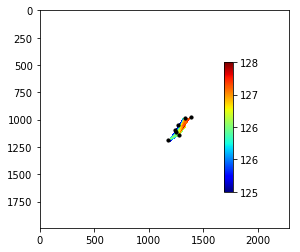

In [287]:
fig,ax = plt.subplots()

#cax = fig.add_axes([0.65, 0.25, 0.02, 0.45])

im = ax.imshow(dem_flat_img.reshape(init_dem_shape), cmap = 'jet')
XY = add_coords(size=init_dem_shape, idx_good_mask=idx_dem)
ax.scatter(XY[res_10[:9], 0], XY[res_10[:9], 1], s=10, color='black')
v1 = np.linspace(dem_no_nodata.min(), dem_no_nodata.max(), 5, endpoint=True)

plt.colorbar(im, cax=cax, orientation='vertical', ticks = v1, format='%.0f')

scalebar = ScaleBar(dx=4.9, location="lower center") # 1 pixel = 0.2 meter
#ax.add_artist(scalebar); 

plt.tick_params(axis='x',which='both',bottom=False,top=False, labelbottom=False)
plt.savefig('oz_f'+str(field)+'_pnts.pdf')


In [292]:
coord_idx

array([[38.61959999, 54.86415522],
       [38.61717303, 54.85714494],
       [38.61667865, 54.86136908],
       [38.61577977, 54.85858295],
       [38.61263371, 54.85516768],
       [38.61533033, 54.85903232],
       [38.62180223, 54.8643799 ]])

In [291]:
xmin, ymin, xmax, ymax = [38.5596900094028996,54.8189928575132015,38.6624762974028968,54.9084188216132034]

st = dem_flat_img.reshape(init_dem_shape)

xv = np.linspace(xmin,xmax, num=st.shape[1])
yv = np.linspace(ymax,ymin, num=st.shape[0])
coords = np.meshgrid(xv,yv)

mask = idx_dem

#select corresponding points by indecies

y_c,x_c = coords[0].flatten()[mask, None],coords[1].flatten()[mask, None]
y_idx, x_idx = y_c[res_10],x_c[res_10]
coord_idx = np.hstack((y_idx,x_idx))

np.savetxt('ozery_points_'+str(field)+'.csv', coord_idx, delimiter=';')

## Coordinates

In [290]:
# idx_dem2 = np.where(dem2_flat != dem_nodata)[0]

In [289]:
# dem2_for_size_raw = gdal.Open('/mnt/bulky/apetrovskaya/Variables_ozery/oz_field_1.tif')
# dem2_nodata = dem2_for_size_raw.GetRasterBand(1).GetNoDataValue()
# dem2_for_size = dem2_for_size_raw.ReadAsArray()
# dem2_flat = dem2_for_size.flatten()

In [288]:
#  fig, axs = plt.subplots(nrows=3, ncols=3, # figsize=(9, 6),
#                         subplot_kw={'xticks': [], 'yticks': []})

# for ax, interp_method in zip(axs.flat, methods):
#     ax.imshow(grid, interpolation=interp_method, cmap='viridis')
#     ax.set_title(str(interp_method))

# plt.tight_layout()
# plt.show()